In [37]:
using POMDPs
using QuickPOMDPs
using Distributions
using Distributions: DiscreteUniform, pdf
using POMDPTools: Deterministic
using POMDPTools
using Statistics
using POMDPs: states, actions, transition, reward
using TabularTDLearning
using Random
using StatsBase: Weights
using Plots
using DataFrames
using POMDPs
using JuMP
using GLPK
using LinearAlgebra
using TabularTDLearning
using POMDPTools: EpsGreedyPolicy, DiscreteBelief

### Theoretical Description of the MDP

We define the environment as a finite Markov Decision Process (MDP) with:

- States: triplet $(s_1, s_2, s_w)$ where:
  - $s_1$: stock in store 1 (values from 0 to 20)
  - $s_2$: stock in store 2 (values from 0 to 20)
  - $s_w$: stock in the central warehouse (values from 0 to 20)

- Actions: $(a_1, a_2, a_w) \in \{0, 1\}^3$ where:
  - $a_1 = 1$: order 5 bikes for store 1
  - $a_2 = 1$: order 5 bikes for store 2
  - $a_w = 1$: trigger warehouse replenishment (10 bikes) if $s_w < 10$

- Transitions:
  - Orders are fulfilled overnight, depending on available capacity
  - Daily demands $d_1, d_2 \sim \text{Uniform}(0, 7)$
  - If store stock is insufficient, home delivery from warehouse is used
  - If warehouse is empty, the demand results in lost sales

- Costs:
  - Ordering: 20€ per truck (per order)
  - Holding:
    - 2€/bike in store
    - 4€/bike in outdoor parking (only for store 1, beyond 10 bikes)
    - 1€/bike in warehouse
  - Home delivery: 10€/bike
  - Lost sale: 50€/bike

- Stochasticity: comes only from demand $d_1$ and $d_2$


The objective is to minimize the expected total discounted cost over an infinite horizon:

$$
\min_{\pi} \mathbb{E} \left[ \sum_{t = 0}^{\infty} \gamma^t \cdot c(s_t, a_t) \right]
$$

with discount factor $\gamma = 0.99$.





In [39]:
### Define the corrected MDP for EddyBikes ###

# Constants
const MAX_INVENTORY = 20             # Maximum inventory in each location
const MAX_STORE = 10                 # Max in-store capacity before using parking
const ORDER_SIZE = 5                 # Number of bikes per store order
const REPLENISH_WAREHOUSE_BATCH = 10  # Number of bikes replenished from factory

# Cost parameters
const holding_cost_store = 2
const holding_cost_parking = 4
const holding_cost_warehouse = 1
const order_cost = 20
const home_delivery_cost = 10
const stockout_penalty = 50

# Demand distribution (Uniform discrete between 0 and 7)
const demand_dist = DiscreteUniform(0, 7)

# Define the MDP using QuickMDP
mdp = QuickMDP(
    # State space: all combinations of inventory levels at each location
    states = [(s1, s2, sw) for s1 in 0:MAX_INVENTORY, s2 in 0:MAX_INVENTORY, sw in 0:MAX_INVENTORY],

    # Action space: binary ordering decisions for each store and the warehouse
    actions = [(a1, a2, aw) for a1 in 0:1, a2 in 0:1, aw in 0:1],

    discount = 0.99,  # Infinite horizon discount factor

    # Transition and reward function
    gen = function (s, a, rng)
        s1, s2, sw = s
        a1, a2, aw = a

        ### Replenishment from factory to warehouse ###
        new_sw = sw + (aw == 1 ? REPLENISH_WAREHOUSE_BATCH : 0)
        new_sw = min(new_sw, MAX_INVENTORY)

        ### Store orders (capped by available space) ###
        order1 = a1 == 1 ? min(ORDER_SIZE, MAX_INVENTORY - s1) : 0
        order2 = a2 == 1 ? min(ORDER_SIZE, MAX_INVENTORY - s2) : 0

        total_requested = order1 + order2

        # Fair allocation if warehouse stock is insufficient
        if total_requested <= new_sw
            actual_order1, actual_order2 = order1, order2
        else
            if s1 < s2
                actual_order1 = min(order1, new_sw)
                actual_order2 = new_sw - actual_order1
            else
                actual_order2 = min(order2, new_sw)
                actual_order1 = new_sw - actual_order2
            end
        end

        actual_order1 = min(actual_order1, ORDER_SIZE)
        actual_order2 = min(actual_order2, ORDER_SIZE)

        # Update inventories
        new_s1 = s1 + actual_order1
        new_s2 = s2 + actual_order2
        new_sw -= (actual_order1 + actual_order2)

        ### Customer demand and fulfillment ###
        d1 = rand(rng, demand_dist)
        d2 = rand(rng, demand_dist)

        # Store 1
        sold1 = min(new_s1, d1)
        remaining_demand1 = d1 - sold1
        delivered1 = min(remaining_demand1, new_sw)
        lost_sales1 = remaining_demand1 - delivered1

        new_s1 -= sold1
        new_sw -= delivered1

        # Store 2
        sold2 = min(new_s2, d2)
        remaining_demand2 = d2 - sold2
        delivered2 = min(remaining_demand2, new_sw)
        lost_sales2 = remaining_demand2 - delivered2

        new_s2 -= sold2
        new_sw -= delivered2

        ### Cost computation ###
        cost = 0

        # Ordering costs
        cost += (a1 == 1 ? order_cost : 0) + (a2 == 1 ? order_cost : 0)

        # Holding costs
        in_store1 = min(new_s1, MAX_STORE)
        in_parking1 = max(new_s1 - MAX_STORE, 0)
        cost += in_store1 * holding_cost_store + in_parking1 * holding_cost_parking
        cost += new_s2 * holding_cost_store
        cost += new_sw * holding_cost_warehouse

        # Delivery and stockout penalties
        cost += (delivered1 + delivered2) * home_delivery_cost
        cost += (lost_sales1 + lost_sales2) * stockout_penalty

        # Reward is negative cost
        r = -cost

        ### Optional: extra info for analysis ###
        total_demand = d1 + d2
        served       = sold1 + sold2
        express      = delivered1 + delivered2
        lost         = lost_sales1 + lost_sales2

        return (
            sp      = (new_s1, new_s2, new_sw),  # next state
            r       = r,                         # reward (negative cost)
            demand  = total_demand,              # total demand
            served  = served,                    # fulfilled directly in store
            express = express,                   # home deliveries
            lost    = lost                       # unmet demand
        )
    end,

    # Initial state: 10 bikes in each location
    initialstate = Deterministic((10, 10, 10))
)


QuickMDP{Base.UUID("0c8b011c-1d37-4159-b9e0-3155fe43ac34"), Tuple{Int64, Int64, Int64}, Tuple{Int64, Int64, Int64}, @NamedTuple{stateindex::Dict{Tuple{Int64, Int64, Int64}, Int64}, isterminal::Bool, actionindex::Dict{Tuple{Int64, Int64, Int64}, Int64}, initialstate::Deterministic{Tuple{Int64, Int64, Int64}}, states::Array{Tuple{Int64, Int64, Int64}, 3}, actions::Array{Tuple{Int64, Int64, Int64}, 3}, discount::Float64, gen::var"#115#118"}}((stateindex = Dict((19, 5, 6) => 2771, (6, 13, 14) => 6454, (20, 16, 1) => 798, (3, 9, 8) => 3721, (0, 2, 19) => 8422, (16, 15, 16) => 7388, (14, 12, 1) => 708, (11, 13, 15) => 6900, (16, 5, 3) => 1445, (18, 6, 19) => 8524…), isterminal = false, actionindex = Dict((0, 0, 0) => 1, (1, 1, 1) => 8, (1, 1, 0) => 4, (0, 1, 1) => 7, (0, 1, 0) => 3, (1, 0, 1) => 6, (1, 0, 0) => 2, (0, 0, 1) => 5), initialstate = Deterministic{Tuple{Int64, Int64, Int64}}((10, 10, 10)), states = [(0, 0, 0) (0, 1, 0) … (0, 19, 0) (0, 20, 0); (1, 0, 0) (1, 1, 0) … (1, 19, 0) (1,

## Optimize the inventory control policy using the Q-learning

In [41]:
global const S = collect(states(mdp))
global const A = collect(actions(mdp))
global const sidx = Dict(s => i for (i,s) in enumerate(S)) # map state  → row
global const aidx = Dict(a => j for (j,a) in enumerate(A)) # map action → col
global ns, na = length(S), length(A)


# N = zeros(Int, 21 * 21 * 21 , 8) 


# N[sidx[(0, 0, 0)], aidx[(0, 1, 0)]] += 100
# N[sidx[(0, 0, 0)], aidx[(0, 1, 0)]]


(9261, 8)

Here we chose our own implementation of the Q-Learning algo over the one from TabularTDLearning, for two main reason (but we also compared both implementation below):
- Control over step-sier $\alpha$ (not fixed)
- Easier to measure the leaning curve


For $\alpha$ we saw by exprimenting that using the **Q-Learning Convergence Theorem (Watkins & Dayan, 1992)**, the algorithm converges better in less iterations than with a fixed step-size (ex: 
using solvers).

The theorem says that: 
- If the MDP is finite
- If the learning rate $\alpha_t(s, a)$ obey the following conditions:
$$\sum_t \alpha_t(s, a) = \infty, \hspace{15mm} \sum_t \alpha_t(s, a)^2 < \infty,\hspace{10mm} \forall (s, a)$$
- The state-action pair is visited $N_t(s,a)$ grows to infinity as t grows to infity for every (s, a) 
- The reward $r_t$ are bounded
  
-> Then 

$$\lim_{t \rightarrow \infty} Q_t(s, a) = Q^*(s, a)$$

with probabilty 1, where the update is:

$$Q_{t + 1}(s_t, a_t) =Q_{t}(s_t, a_t) +  \alpha_t(s_t, a_t) (r_t + \gamma \max_{a'} Q_t(s_{t + 1} , a')  - Q_t(s_t, a_t) ) $$


So, we chose:

$$\alpha_t(s_t, a_t) = \frac{1}{N_t(a, s)}$$

In [ ]:
function my_q_learning_with_tracking(mdp;
    ε::Float64         = 0.1,
    epochs::Int        = 150,
    iterations::Int    = 100_000,
    track_every::Int   = 1000,
    eval_episodes::Int = 100,
    γ::Float64         = discount(mdp),
    rng::AbstractRNG   = MersenneTwister(0)
)

    S = collect(states(mdp))
    A = collect(actions(mdp))
    ns, na = length(S), length(A)

    sidx = Dict(s => i for (i,s) in enumerate(S))
    aidx = Dict(a => j for (j,a) in enumerate(A))

    Q = zeros(ns, na)
    N = zeros(Int, ns, na)

    err = Float64[]
    learning_curve = Float64[]

    for k in 1:iterations
        Q_old = copy(Q)

        for _ in 1:epochs
            s = Tuple(rand(0:20, 3))  # même init que SARSA

            for _ in 1:30
                si = sidx[s]
                a  = rand(rng) < ε ? rand(rng, A) : A[argmax(@view Q[si, :])]
                ai = aidx[a]

                out = POMDPs.gen(mdp, s, a, rng)
                sp, r = out.sp, out.r
                spi = sidx[sp]

                N[si, ai] += 1
                α = 1.0 / N[si, ai]
                Q[si, ai] += α * (r + γ * maximum(@view Q[spi, :]) - Q[si, ai])

                s = sp
            end
        end

        if k % 100 == 0
            push!(err, norm(Q - Q_old))
        end

        if k % track_every == 0
            total_cost = 0.0
            for _ in 1:eval_episodes
                s = Tuple(rand(0:20, 3))
                for _ in 1:30
                    si = sidx[s]
                    a = A[argmax(@view Q[si, :])]
                    out = POMDPs.gen(mdp, s, a, rng)
                    s, r = out.sp, out.r
                    total_cost -= r
                end
            end
            push!(learning_curve, total_cost / eval_episodes)
        end

        k % 10_000 == 0 && println("iter = $k  ‖ΔQ‖₂ = $(err[end])")
    end

    return Q, err, learning_curve
end

my_q_learning_with_tracking (generic function with 1 method)

In [ ]:
Q_qlearn, err_qlearn, learning_curve_qlearn = my_q_learning_with_tracking(mdp;
    ε = 0.1,
    epochs = 150,
    iterations = 100_000,
    track_every = 1000,
    eval_episodes = 100,
    γ = discount(mdp),
    rng = MersenneTwister(0))

iter = 10000  ‖ΔQ‖₂ = 32.307428643701776
iter = 20000  ‖ΔQ‖₂ = 13.118703590277546
iter = 30000  ‖ΔQ‖₂ = 10.534789738738807
iter = 40000  ‖ΔQ‖₂ = 8.654420279250301
iter = 50000  ‖ΔQ‖₂ = 8.571896157801511
iter = 60000  ‖ΔQ‖₂ = 7.714970789635135
iter = 70000  ‖ΔQ‖₂ = 4.936127726775662
iter = 80000  ‖ΔQ‖₂ = 4.510201437501767
iter = 90000  ‖ΔQ‖₂ = 4.453998927268352
iter = 100000  ‖ΔQ‖₂ = 3.748269497819647


([-896.7395044234112 -916.7235549401908 … -597.3625497504546 -597.3625385823292; -850.5635572938384 -871.1807325414766 … -580.6112213809546 -580.6096212760953; … ; -616.5800122146186 -616.6895266548155 … -616.5251026861234 -644.7372518973767; -627.2374008795389 -627.6455411831472 … -627.7076651593209 -635.0635173675028], [2692.754058633728, 1731.5108990890324, 1116.96551080859, 619.0561523785751, 597.8981726100376, 480.2070555060372, 462.46425414882884, 361.69420764167535, 328.4022251950261, 291.24875400312106  …  3.7465376118526255, 4.610099309832213, 5.801147515878293, 3.566542214750389, 4.362466173110079, 2.6911548105176935, 4.105247784071302, 3.226750765342931, 4.094839157351979, 3.748269497819647], [1645.69, 1600.85, 1593.86, 1573.43, 1575.57, 1558.47, 1588.77, 1548.61, 1566.33, 1572.61  …  1500.58, 1512.9, 1510.58, 1500.75, 1513.31, 1518.48, 1501.08, 1493.58, 1495.79, 1512.38])

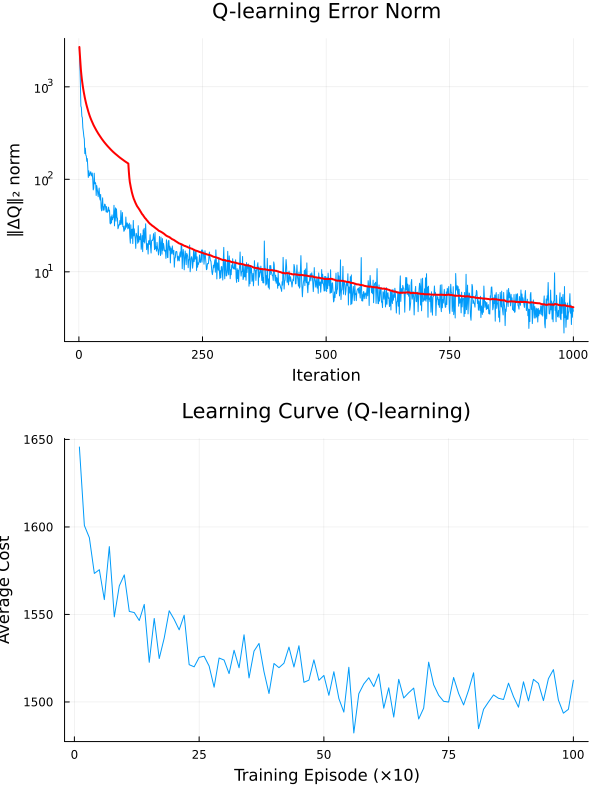

In [49]:
### Plot 1: Q-learning Error Norm ###
# We compute a moving average of the Q-error norm over a sliding window
window_size = 100
moving_avg_err = [mean(err_qlearn[max(1, i - window_size + 1):i]) for i in 1:length(err_qlearn)]

p1 = plot(
    err_qlearn,
    xlabel = "Iteration",
    ylabel = "‖ΔQ‖₂ norm",
    title = "Q-learning Error Norm",
    legend = false,
    yscale = :log10
)
# Overlay the moving average to smooth the visualization
plot!(p1, moving_avg_err, label = "Moving Average", linewidth = 2, color = :red)

### Plot 2: Learning Curve ###
# The average cost is evaluated every 10 episodes during training.
# Therefore, point i on the curve corresponds to episode 10*i.
p2 = plot(
    learning_curve_qlearn,
    xlabel = "Training Episode (×10)",
    ylabel = "Average Cost",
    title = "Learning Curve (Q-learning)",
    legend = false
)


plot(p1, p2, layout = (2, 1), size = (600, 800))



This curve represents the evolution of the average discounted cost over 100 evaluation episodes, computed every 10 training episodes.
The policy is derived by acting greedily with respect to the learned Q-table, starting from a random initial state and simulating a finite-horizon trajectory of 30 steps.
We observe a consistent decrease in the average cost—from around 1650 to approximately 1500—indicating that the policy improves as training progresses.
This trend aligns well with the decrease in the Q-error norm (‖ΔQ‖₂), providing evidence that the agent is converging towards a more cost-efficient behavior.

In [50]:
function simulate_episode(mdp, Q, sidx, aidx; γ=0.99, rng=MersenneTwister(1))
    s = Tuple(rand(0:20, 3))  # état initial aléatoire
    total_cost = 0.0

    for t in 1:30  # horizon fini ou nombre max d'étapes par épisode
        si = sidx[s]
        a  = argmax(Q[si, :])
        a = collect(actions(mdp))[a]
        out = POMDPs.gen(mdp, s, a, rng)
        sp, r = out.sp, out.r

        total_cost += (γ^(t - 1)) * r
        s = sp
    end

    return total_cost
end

function evaluate_policy(mdp, Q, sidx, aidx; episodes=1000)
    costs = Float64[]
    for _ in 1:episodes
        c = simulate_episode(mdp, Q, sidx, aidx)
        push!(costs, c)
    end
    return costs
end


evaluate_policy (generic function with 1 method)

In [51]:
costs = evaluate_policy(mdp, Q_l, sidx, aidx)
using Plots
plot(costs, title="Coût par épisode (Q-learning)", xlabel="Épisode", ylabel="Coût total")


UndefVarError: UndefVarError: `Q_l` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [52]:

N_eval = 1000
total_rewards = zeros(N_eval)
n_epoch = 30

greedy_action(s) = A[argmax(@view Q_l[sidx[s], :])]

for k in 1:N_eval
    # s = (10, 10, 10)
    s  = Tuple(rand(0:20, 3))        # start state

    total_r = 0.0

    rng =  MersenneTwister()
    for t in 1:n_epoch
        # a = π_ql[s]  
        # a = POMDPs.actions(mdp, ql_policy, s)
        a = greedy_action(s)
        s, r  = POMDPs.gen(mdp, s, a, rng)
        # s, r = out.sp, out.r
        total_r += r * discount(mdp)^(t - 1)
        # total_r += r
        # total_r = r +  total_r * 0.99
    end
    total_rewards[k] = total_r
end

@show mean_r = mean(total_rewards)
@show std_r = std(total_rewards)
# println(mean_r, " ", std_r)

UndefVarError: UndefVarError: `Q_l` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

## Using solvers

In [12]:
α = 1e-5
ϵ = 0.1
n_episodes = 100_000 *30


ql_solver   = QLearningSolver(
                 exploration_policy = EpsGreedyPolicy(mdp, ϵ),
                 learning_rate      = α,
                 n_episodes         = n_episodes,
                 max_episode_length = 150,
                 eval_every         = Int(n_episodes/10),
                 n_eval_traj        = 100,
                 verbose = false)


res_q = solve(ql_solver, mdp)


ValuePolicy{QuickMDP{Base.UUID("165ff120-5ff0-4d93-8f8f-2cd4fa332347"), Tuple{Int64, Int64, Int64}, Tuple{Int64, Int64, Int64}, @NamedTuple{stateindex::Dict{Tuple{Int64, Int64, Int64}, Int64}, isterminal::Bool, actionindex::Dict{Tuple{Int64, Int64, Int64}, Int64}, initialstate::Deterministic{Tuple{Int64, Int64, Int64}}, states::Array{Tuple{Int64, Int64, Int64}, 3}, actions::Array{Tuple{Int64, Int64, Int64}, 3}, discount::Float64, gen::var"#15#18"}}, Matrix{Float64}, Tuple{Int64, Int64, Int64}}:
 (0, 0, 0) -> (1, 1, 1)
 (1, 0, 0) -> (1, 1, 1)
 (2, 0, 0) -> (1, 0, 1)
 (3, 0, 0) -> (0, 1, 1)
 (4, 0, 0) -> (0, 1, 1)
 (5, 0, 0) -> (0, 1, 1)
 (6, 0, 0) -> (0, 1, 1)
 (7, 0, 0) -> (0, 1, 1)
 (8, 0, 0) -> (0, 1, 1)
 (9, 0, 0) -> (0, 0, 1)
 (10, 0, 0) -> (0, 1, 1)
 (11, 0, 0) -> (0, 0, 0)
 (12, 0, 0) -> (1, 0, 1)
 (13, 0, 0) -> (0, 0, 1)
 (14, 0, 0) -> (1, 1, 1)
 (15, 0, 0) -> (1, 0, 1)
 (16, 0, 0) -> (1, 0, 0)
 (17, 0, 0) -> (1, 1, 0)
 (18, 0, 0) -> (0, 0, 1)
 (19, 0, 0) -> (1, 0, 1)
 …

In [13]:

N_eval = 1000
total_rewards = zeros(N_eval)

for k in 1:N_eval
    s = (10, 10, 10)
    total_r = 0.0

    rng =  MersenneTwister()
    for t in 1:15
        # a = π_ql[s]  
        # a = POMDPs.actions(mdp, ql_policy, s)
        a = action(res_q, s)
        s, r  = POMDPs.gen(mdp, s, a, rng)
        # s, r = out.sp, out.r
        # total_r += r * discount(mdp)^(t - 1)
        # total_r += r
        total_r = r +  total_r * 0.99
    end
    total_rewards[k] = total_r
end

@show mean_r = mean(total_rewards)
@show std_r = std(total_rewards)
# println(mean_r, " ", std_r)

mean_r = mean(total_rewards) = -857.84239787639
std_r = std(total_rewards) = 125.53180693789034


125.53180693789034

# SARSA

In [ ]:
### SARSA Algorithm with Policy Evaluation and Q-error Tracking ###

@inline function egreedy_action(Qrow, A, ε, rng)
    # ε-greedy exploration policy
    return rand(rng) < ε ? rand(rng, A) : A[argmax(Qrow)]
end

function my_sarsa_with_tracking(mdp;
    ε::Float64         = 0.1,             # Exploration rate
    epochs::Int        = 150,             # Episodes per outer iteration
    iterations::Int    = 100_000,         # Number of outer iterations
    track_every::Int   = 1000,            # Evaluation frequency
    eval_episodes::Int = 100,             # Episodes per evaluation
    γ::Float64         = discount(mdp),   # Discount factor
    rng::AbstractRNG   = MersenneTwister(0)
)

    # State and action space indexing
    S = collect(states(mdp))
    A = collect(actions(mdp))
    ns, na = length(S), length(A)

    sidx = Dict(s => i for (i, s) in enumerate(S))
    aidx = Dict(a => j for (j, a) in enumerate(A))

    # Initialize Q-values and visit counters
    Q = zeros(ns, na)
    N = zeros(Int, ns, na)

    # Tracking: error norm and learning curve
    err = Float64[]              # ‖ΔQ‖₂ tracking
    learning_curve = Float64[]   # Average cost per evaluation

    for k in 1:iterations
        Q_old = copy(Q)

        # --- Training phase over multiple episodes ---
        for _ in 1:epochs
            s  = Tuple(rand(0:20, 3))  # Random initial state
            si = sidx[s]
            a  = egreedy_action(view(Q, si, :), A, ε, rng)
            ai = aidx[a]

            for _ in 1:30  # Fixed horizon
                out = POMDPs.gen(mdp, s, a, rng)
                sp, r = out.sp, out.r

                spi = sidx[sp]
                ap  = egreedy_action(view(Q, spi, :), A, ε, rng)
                api = aidx[ap]

                # SARSA Q-value update with adaptive step-size
                N[si, ai] += 1
                α = 1.0 / N[si, ai]
                Q[si, ai] += α * (r + γ * Q[spi, api] - Q[si, ai])

                # Move to next state-action
                s = sp; si = spi
                a = ap; ai = api
            end
        end

        # --- Track Q-error norm every 100 iterations ---
        if k % 100 == 0
            push!(err, norm(Q - Q_old))
        end

        # --- Evaluate greedy policy periodically ---
        if k % track_every == 0
            total_cost = 0.0
            for _ in 1:eval_episodes
                s = Tuple(rand(0:20, 3))
                for _ in 1:30
                    si = sidx[s]
                    a = A[argmax(@view Q[si, :])]
                    out = POMDPs.gen(mdp, s, a, rng)
                    s, r = out.sp, out.r
                    total_cost -= r  # r is negative cost
                end
            end
            push!(learning_curve, total_cost / eval_episodes)
        end

        k % 10_000 == 0 && println("iter = $k  ‖ΔQ‖₂ = $(err[end])")
    end

    return Q, err, learning_curve
end




my_sarsa_with_tracking (generic function with 1 method)

In [ ]:
Q_sarsa, err_sarsa, learning_curve_sarsa = my_sarsa_with_tracking(mdp;
    ε = 0.1,
    epochs = 150,
    iterations = 100_000,
    track_every = 1000,
    eval_episodes = 100,
    γ = discount(mdp),
    rng = MersenneTwister(0))


iter = 10000  ‖ΔQ‖₂ = 29.754651761601973
iter = 20000  ‖ΔQ‖₂ = 11.286070155731958
iter = 30000  ‖ΔQ‖₂ = 8.771230508111325
iter = 40000  ‖ΔQ‖₂ = 7.471704464567885
iter = 50000  ‖ΔQ‖₂ = 5.263340732420513
iter = 60000  ‖ΔQ‖₂ = 4.445156404498161
iter = 70000  ‖ΔQ‖₂ = 4.739464551973269
iter = 80000  ‖ΔQ‖₂ = 3.7804157012623985
iter = 90000  ‖ΔQ‖₂ = 5.398614398535901
iter = 100000  ‖ΔQ‖₂ = 4.701965136961613


([-952.6632230447989 -974.5341487604236 … -652.3362998711253 -643.1379638860247; -908.3328563594829 -926.5124430331555 … -628.9805932543401 -628.9812152164933; … ; -634.8200591445953 -635.0312924789223 … -636.2300410510659 -638.0993975529675; -648.6856935620177 -648.7445109564441 … -648.5931445058585 -653.7633155490124], [2918.6685805166335, 1758.6690836245361, 1100.2047695986726, 752.1011280144625, 455.1247724419786, 669.8919321459805, 378.4231271444727, 259.5016192653336, 267.09345258528475, 302.19076296855  …  4.824473935260351, 4.504807238753093, 4.899952458029411, 7.669821445050543, 4.009116998710318, 6.731363872843346, 4.690419227098799, 5.059613114134634, 2.687021657077486, 4.701965136961613], [1691.23, 1653.5, 1637.88, 1608.91, 1615.2, 1612.83, 1624.17, 1601.04, 1603.69, 1586.3  …  1553.56, 1543.89, 1538.42, 1548.54, 1542.59, 1549.03, 1542.05, 1541.6, 1536.44, 1556.56])

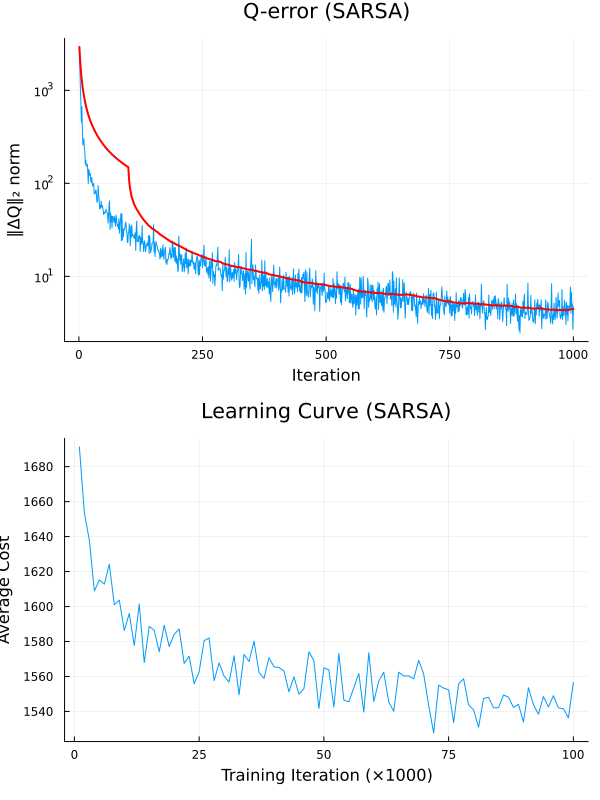

In [ ]:
### Plotting SARSA Results ###

using Statistics, Plots

### Plot 1: Q-update error norm (‖ΔQ‖₂) ###
# Compute the moving average of the Q-error norm to smooth the curve
window_size = 100
moving_avg_err = [mean(err_sarsa[max(1, i - window_size + 1):i]) for i in 1:length(err_sarsa)]

p1 = plot(
    err_sarsa,
    xlabel = "Iteration",
    ylabel = "‖ΔQ‖₂ norm",
    title = "Q-error (SARSA)",
    legend = false,
    yscale = :log10
)
# Add the moving average overlay
plot!(p1, moving_avg_err, label = "Moving Average", linewidth = 2, color = :red)

### Plot 2: Learning curve (average cost) ###
# Each point represents the average cost over 100 evaluation episodes,
# evaluated every 1000 training iterations
p2 = plot(
    learning_curve_sarsa,
    xlabel = "Training Iteration (×10)",
    ylabel = "Average Cost",
    title = "Learning Curve (SARSA)",
    legend = false
)

plot(p1, p2, layout = (2, 1), size = (600, 800))


The top plot shows the evolution of the Q-update error norm (‖ΔQ‖₂), which steadily decreases throughout training, from approximately 30 to values below 5.
This suggests that the Q-table is progressively stabilizing.

The bottom plot shows the learning curve, i.e., the average cost per evaluation, computed every 1000 iterations over 100 episodes.
The cost decreases from about 1680 to approximately 1540, which indicates that the policy is becoming more efficient over time.

Although SARSA’s convergence is slightly more irregular than Q-learning due to its on-policy nature, the overall trend still confirms learning progress and policy improvement

Here, we use the same ideas from the Q-Leanring but adpated it to to the SARSA update.

In [14]:
@inline function egreedy_action(Qrow, A, ε, rng)
    return rand(rng) < ε ? rand(rng, A) : A[argmax(Qrow)]
end

function my_sarsa(mdp;
                  ε::Float64        = 0.1,
                  epochs::Int       = 100,
                  iterations::Int   = 10_000,
                  γ::Float64        = discount(mdp),
                  rng::AbstractRNG  = MersenneTwister(0))

    # S   = collect(states(mdp));    ns = length(S)
    # A   = collect(actions(mdp));   na = length(A)
    # sidx = Dict(s => i for (i,s) in enumerate(S))
    # aidx = Dict(a => j for (j,a) in enumerate(A))

    Q = zeros(ns, na)      # Q‑table
    N = zeros(Int, ns, na) # visit counters
    err = Float64[]

    for k in 1:iterations
        Q_old = copy(Q)

        for _ in 1:epochs
            # s  = rand(rng, initialstate(mdp))        
            s  = Tuple(rand(0:20, 3))     
            si = sidx[s]
            a  = egreedy_action(view(Q, si, :), A, ε, rng)
            ai = aidx[a]

            for _ in 1:30
                out = POMDPs.gen(mdp, s, a, rng)
                sp, r = out.sp, out.r
                spi   = sidx[sp]

                ap  = egreedy_action(view(Q, spi, :), A, ε, rng)
                api = aidx[ap]

                N[si, ai] += 1;  α = 1.0 / N[si, ai]
                Q[si, ai] += α * (r + γ * Q[spi, api] - Q[si, ai])

                s  = sp;  si = spi;  a = ap;  ai = api
            end
        end

        if k % 100 == 0
            push!(err, norm(Q - Q_old))
        end
        k % 10_000 == 0 && println("iter = $k  ‖ΔQ‖₂ = $(err[end])")
    end
    return Q, err
end

Q_s, errs = my_sarsa(mdp; ε=0.1, epochs=150, iterations=100_000)
S = collect(states(mdp)); sidx = Dict(s => i for (i,s) in enumerate(S))
println("Finished SARSA.  Max‑Q for initial state = ",
        maximum(Q_s[sidx[(10,10,10)], :]))


iter = 10000  ‖ΔQ‖₂ = 35.49081153904376
iter = 20000  ‖ΔQ‖₂ = 13.992510549688019
iter = 30000  ‖ΔQ‖₂ = 12.81346421606627
iter = 40000  ‖ΔQ‖₂ = 10.702581936485391
iter = 50000  ‖ΔQ‖₂ = 6.72300675279403
iter = 60000  ‖ΔQ‖₂ = 4.967274987474169
iter = 70000  ‖ΔQ‖₂ = 5.252239836216103
iter = 80000  ‖ΔQ‖₂ = 4.090925404591497
iter = 90000  ‖ΔQ‖₂ = 4.118896082293687
iter = 100000  ‖ΔQ‖₂ = 3.7356450303302946


Finished SARSA.  Max‑Q for initial state = -540.8516475099476


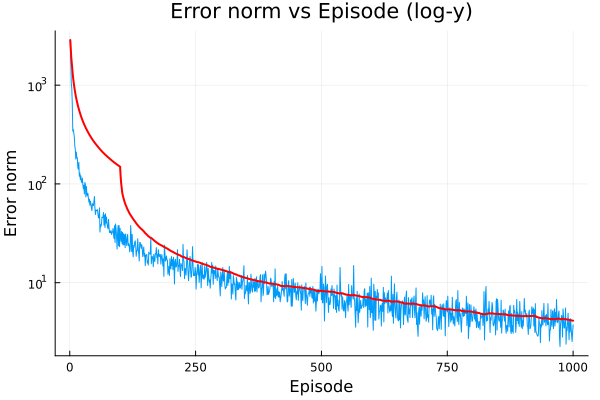

In [ ]:
window_size = 100  # choose your smoothing window
moving_avg = [mean(errs[max(1, i-window_size+1):i]) for i in 1:length(errs)]

plot(
  errs,
  xlabel    = "Episode",
  ylabel    = "Error norm",
  title     = "Error norm vs Episode (log‐y)",
  legend    = false,
  yscale    = :log10,       # ◀── here’s the magic
  # xscale    = :log10,       # ◀── here’s the magic
)
plot!(moving_avg, label = "Moving average", linewidth = 2, color = :red)

#### ADD COMMENT ON THE PLOT !!!

In [16]:

N_eval = 1000
total_rewards = zeros(N_eval)
n_epoch = 30

greedy_action(s) = A[argmax(@view Q_s[sidx[s], :])]

for k in 1:N_eval
    # s = (10, 10, 10)
    s = Tuple(rand(1:20, 3))

    total_r = 0.0

    rng =  MersenneTwister()
    for t in 1:n_epoch
        # a = π_ql[s]  
        # a = POMDPs.actions(mdp, ql_policy, s)
        a = greedy_action(s)
        s, r  = POMDPs.gen(mdp, s, a, rng)
        # s, r = out.sp, out.r
        total_r += r * discount(mdp)^(t - 1)
        # total_r += r
        # total_r = r +  total_r * 0.99
    end
    total_rewards[k] = total_r
end

@show mean_r = mean(total_rewards)
@show std_r = std(total_rewards)
# println(mean_r, " ", std_r)

mean_r = mean(total_rewards) = -1351.7984610644596
std_r = std(total_rewards) = 69.03345559294813


69.03345559294813

## Sarsa solvers

In [17]:
α = 1e-7
ϵ = 0.1
n_episodes = 100_000 * 30



sarsa_solver   = SARSASolver(
    exploration_policy = EpsGreedyPolicy(mdp, ϵ),
    learning_rate      = α,
    n_episodes         = n_episodes,
    max_episode_length = 150,
    eval_every         = 10000,
    n_eval_traj        = 100)


res_s = solve(ql_solver, mdp)

ValuePolicy{QuickMDP{Base.UUID("165ff120-5ff0-4d93-8f8f-2cd4fa332347"), Tuple{Int64, Int64, Int64}, Tuple{Int64, Int64, Int64}, @NamedTuple{stateindex::Dict{Tuple{Int64, Int64, Int64}, Int64}, isterminal::Bool, actionindex::Dict{Tuple{Int64, Int64, Int64}, Int64}, initialstate::Deterministic{Tuple{Int64, Int64, Int64}}, states::Array{Tuple{Int64, Int64, Int64}, 3}, actions::Array{Tuple{Int64, Int64, Int64}, 3}, discount::Float64, gen::var"#15#18"}}, Matrix{Float64}, Tuple{Int64, Int64, Int64}}:
 (0, 0, 0) -> (1, 1, 1)
 (1, 0, 0) -> (1, 1, 1)
 (2, 0, 0) -> (1, 0, 1)
 (3, 0, 0) -> (0, 1, 1)
 (4, 0, 0) -> (0, 1, 1)
 (5, 0, 0) -> (0, 1, 1)
 (6, 0, 0) -> (1, 1, 1)
 (7, 0, 0) -> (0, 1, 1)
 (8, 0, 0) -> (1, 0, 1)
 (9, 0, 0) -> (0, 1, 1)
 (10, 0, 0) -> (1, 0, 1)
 (11, 0, 0) -> (1, 1, 1)
 (12, 0, 0) -> (0, 0, 1)
 (13, 0, 0) -> (1, 1, 0)
 (14, 0, 0) -> (1, 0, 1)
 (15, 0, 0) -> (1, 1, 0)
 (16, 0, 0) -> (0, 1, 1)
 (17, 0, 0) -> (1, 0, 0)
 (18, 0, 0) -> (1, 0, 1)
 (19, 0, 0) -> (0, 0, 1)
 …

In [18]:
N_eval = 1000
total_rewards = zeros(N_eval)

for k in 1:N_eval
    s = (10, 10, 10)
    total_r = 0.0

    rng =  MersenneTwister()
    for t in 1:15
        # a = π_ql[s]  
        # a = POMDPs.actions(mdp, ql_policy, s)
        a = action(res_s, s)
        s, r  = POMDPs.gen(mdp, s, a, rng)
        # s, r = out.sp, out.r
        total_r += r * discount(mdp)^(t - 1)
        # total_r += r
        # total_r = r +  total_r * 0.99
    end
    total_rewards[k] = total_r
end

@show mean_r = mean(total_rewards)
@show std_r = std(total_rewards)
# println(mean_r, " ", std_r)

mean_r = mean(total_rewards) = -863.6808920902276
std_r = std(total_rewards) = 139.7946375531752


139.7946375531752

# Q3 Heuristic Policy

Here is the simple heuristic implementation.

In [19]:
function heuristic(s::Tuple{Int, Int, Int})
    a = [0, 0, 0]  # mutable array
    if s[1] < 7
        a[1] = 1
    end
    if s[2] < 7
        a[2] = 1
    end
    if s[3] < 10
        a[3] = 1
    end
    return a
end


heuristic (generic function with 1 method)

In [20]:

N_eval = 1000
total_rewards = zeros(N_eval)
n_epoch = 30

greedy_action(s) = A[argmax(@view Q[sidx[s], :])]

for k in 1:N_eval
    s = (10, 10, 10)
    # s = Tuple(rand(1:20, 3))

    total_r = 0.0

    rng =  MersenneTwister()
    for t in 1:n_epoch
        # a = π_ql[s]  
        # a = POMDPs.actions(mdp, ql_policy, s)
        a = heuristic(s)
        s, r  = POMDPs.gen(mdp, s, a, rng)
        # s, r = out.sp, out.r
        total_r += r * discount(mdp)^(t - 1)
        # total_r += r
        # total_r = r +  total_r * 0.99
    end
    total_rewards[k] = total_r
end

@show mean_r = mean(total_rewards)
@show std_r = std(total_rewards)

mean_r = mean(total_rewards) = -1401.0669298971038
std_r = std(total_rewards) = 49.609789823355804


49.609789823355804

# Q4 - Analyze using steady states probs

Here we simulate each policies $\pi :  \mathcal S \rightarrow \mathcal A$. $\pi$ is frozen then our controlled system becomes time-homgenous such that :

$$P_\pi(s, s') = P(s' | s, \pi(s))$$
The long‑run properties of that MDP are captured by its stationarydistribution $\mu_\pi$, if it exists and is unique then $\mu_\pi = \mu_\pi P_\pi$ and $\sum_s \mu_\pi(s) = 1$. 

With this we can estimate steady-state metric such as:

- The average bike per shop: $\bar{s} = \sum_s \mu_\pi(s) s$
- The service level: $\mathbf E_{\mu_\pi}$[serverved / total demand]
- Long-run expected cost:  $\mathbf E_{\mu_\pi}[r(s, \pi(s))]$

We expect the simulation to work because we suppose that every state of the MDP is reachable because of the randomness of the demand, then for evey bounded function that we wish to estimate:

$$\frac{1}{T} \sum_t f(s_t) \longrightarrow \sum_s \mu_\pi(s) f(s), \hspace{10mm} T \rightarrow \infty$$

We estimate $\mu_\pi$ as visited / sum(vistited)

In [21]:
function simulate_policy!(mdp, π;
    steps::Int       = 1_000_000,
    burn_in::Int     = 100_000,
    rng::AbstractRNG = Random.GLOBAL_RNG,
    using_solver::Bool = false )

    visits     = zeros(Int, ns)
    demand_t   = 0
    served_t   = 0
    express_t  = 0
    lost_t     = 0
    cost_t     = 0.0

    
    # s = Tuple(rand(0:10, 3))
    # s = rand(rng, initialstate(mdp))
    s = (10, 10, 10)
    total = steps + burn_in
    a = undef
    
    for t in 1:total
        if using_solver
            a = POMDPs.action(π, s)
        else
            a   = π(s)
        end


        out = POMDPs.gen(mdp, s, a, rng)
        sp, r = out.sp, out.r

        if t > burn_in
            idx = sidx[sp]
            visits[idx] += 1
            # println("HELLO")
            demand_t  += out.demand
            served_t  += out.served
            express_t += out.express
            lost_t    += out.lost
            cost_t    += out.r    
        end

        s = sp
    end

    μ = visits ./ sum(visits)
    # μ, _ = empirical_stationary(mdp, π)
    # println("Hello")

    avg_s1 = sum(μ[i] * S[i][1] for i in 1:ns)
    avg_s2 = sum(μ[i] * S[i][2] for i in 1:ns)
    avg_sw = sum(μ[i] * S[i][3] for i in 1:ns)

    p_served  = served_t  / demand_t
    p_express = express_t / demand_t
    p_lost    = lost_t    / demand_t

    avg_cost  = cost_t / steps


    return (
            μ          = μ,
            inventory  = (avg_s1, avg_s2, avg_sw),
            service    = (p_served, p_express, p_lost),
            avg_cost   = avg_cost,
            )
end

simulate_policy! (generic function with 1 method)

In [22]:
greedy_rl(s)    = A[argmax(view(Q_l,    sidx[s], :))]
greedy_sarsa(s) = A[argmax(view(Q_s, sidx[s], :))]

info_rl    = simulate_policy!(mdp, greedy_rl)
info_sarsa = simulate_policy!(mdp, greedy_sarsa)
info_heur  = simulate_policy!(mdp, heuristic)

println("QL inventory  : ", info_rl.inventory)
println("QL service KPIs (served, express, lost): ", info_rl.service)
println("QL avg cost  (EUR/STEP) : ", info_rl.avg_cost)
println()


println("QS inventory  : ", info_sarsa.inventory)
println("QS service KPIs (served, express, lost): ", info_sarsa.service)
println("QS avg cost  (EUR/STEP) : ", info_sarsa.avg_cost)
println()

println("Heuristic inventory  : ", info_heur.inventory)
println("Heuristic service KPIs (served, express, lost): ", info_heur.service)
println("Heuristic avg cost (EUR/STEP)  : ", info_heur.avg_cost)
println()



info_rl_solver    = simulate_policy!(mdp, res_q, using_solver=true)


println("QL (using solver) inventory  : ", info_rl_solver.inventory)
println("QL (using solver) service KPIs (served, express, lost): ", info_rl_solver.service)
println("QL (using solver) avg cost  (EUR/STEP) : ", info_rl_solver.avg_cost)
println()

info_sarsa_solver    = simulate_policy!(mdp, res_s, using_solver=true)


println("QS (using solver) inventory  : ", info_sarsa_solver.inventory)
println("QS (using solver) service KPIs (served, express, lost): ", info_sarsa_solver.service)
println("QS (using solver) avg cost  (EUR/STEP) : ", info_sarsa_solver.avg_cost)
println()




QL inventory  : (3.0558639999999877, 2.989635000000002, 5.535580999999985)
QL service KPIs (served, express, lost): (0.9165003672177938, 0.08109605141449662, 0.002403581367709611)
QL avg cost  (EUR/STEP) : -49.835085

QS inventory  : (3.3212239999999933, 3.431892000000002, 6.788989999999977)
QS service KPIs (served, express, lost): (0.923245412678641, 0.07570288662923574, 0.0010517006921232973)
QS avg cost  (EUR/STEP) : -51.920816

Heuristic inventory  : (4.915175000000005, 4.920651999999995, 7.166831999999982)
Heuristic service KPIs (served, express, lost): (0.990742448150973, 0.007924360479189598, 0.0013331913698373624)
Heuristic avg cost (EUR/STEP)  : -55.661058

QL (using solver) inventory  : (2.982668999999989, 3.2606029999999957, 6.818798999999979)
QL (using solver) service KPIs (served, express, lost): (0.7987101930226118, 0.1835309326458095, 0.01775887433157868)
QL (using solver) avg cost  (EUR/STEP) : -61.713319

QS (using solver) inventory  : (3.1087809999999827, 3.0007489999

### ADD FINAL COMMENT 